## Testing QuakeFlow on Alaska data

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Create obspy catalog object from quakeml file

In [4]:
cat = obspy.core.event.read_events('XO_2018_10.quakeml')
print(cat)

437 Event(s) in Catalog:
2018-10-01T06:02:23.795000Z | +57.940, -153.929 | 2.1 ml | manual
2018-10-01T08:35:07.702000Z | +57.139, -156.563 | 2.5 ml | manual
...
2018-10-31T11:05:22.076000Z | +56.208, -148.992 | 2.4 ml | manual
2018-10-31T20:03:47.517000Z | +55.858, -149.523 | 2.4 ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


#### Pick an event to try out, and look at how many picks it has

In [5]:
event = cat.events[2]
print('Earthquake on',str(event.origins[0].time))
print('Earthquake has',str(len(event.picks)),'picks')
print('Earthquake magnitude is',str(event.magnitudes[0].mag))

Earthquake on 2018-10-01T09:42:17.906000Z
Earthquake has 26 picks
Earthquake magnitude is 1.4


#### Now let's get a list of the stations that have picks

This will be in the form networkcode.stationcode.locationcode.channelbase

In [6]:
networks = [p.waveform_id.network_code for p in event.picks]
stations = [p.waveform_id.station_code for p in event.picks]
channels = [p.waveform_id.channel_code[0:2] + "*" for p in event.picks]

# Python 'f' strings are quite handy for string formatting:
sta_list = [f"{n}.{s}..{c[0:2]}" for n, s, c in zip(networks, stations, channels)]

print(sta_list)

['AV.KCE..EH', 'XO.ET20..HH', 'AV.KCG..EH', 'AV.KVT..EH', 'AV.ANCK..BH', 'XO.ET19..HH', 'AV.ANCK..BH', 'AV.KJL..BH', 'XO.ET19..HH', 'AV.KEL..EH', 'AV.KAHG..BH', 'AV.Q18K..BH', 'XO.ET17..HH', 'XO.EP15..HH', 'AV.Q18K..BH', 'AK.R18K..BH', 'XO.KT06..HH', 'TA.Q16K..BH', 'AK.P17K..BH', 'XO.ET17..HH', 'XO.EP15..HH', 'AV.KABU..BH', 'AV.ACH..BH', 'AV.KCG..EH', 'AV.KABU..BH', 'AV.ACH..BH']


#### Let's get the station information for those stations from IRIS

In [14]:
station

'ACH,ANCK,EP15,ET17,ET19,ET20,KABU,KAHG,KCE,KCG,KEL,KJL,KT06,KVT,P17K,Q16K,Q18K,R18K'

In [21]:
network = ",".join((np.unique(networks)).tolist())
channel = ",".join((np.unique(channels)).tolist())
station = ",".join((np.unique(stations)).tolist())
starttime = event.origins[0].time

sta_metadata = Client("iris").get_stations(starttime = starttime, endtime  = starttime + 30,network = network,channel=channel,station=station,level='response',location='')
    
print(sta_metadata)

Inventory created at 2022-01-12T01:03:10.543000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-10-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (3):
			AV, TA, XO
		Stations (18):
			AV.ACH (Angle Creek Headwaters, Katmai, Alaska)
			AV.ANCK (Angle Creek, Katmai Volcanic Cluster, Alaska)
			AV.KABU (KABU - Katmai Volcanic Cluster, Alaska)
			AV.KAHG (Katmai Hook Glacier, Alaska)
			AV.KCE (Katmai Cerebus, Alaska)
			AV.KCG (Knife Creek Glacier, Katmai, Alaska)
			AV.KEL (Katmai Kelez, Alaska)
			AV.KJL (Kejulik, Katmai, Alaska)
			AV.KVT (Katmai Valley of 10,000 Smokes, Alaska)
			TA.P17K (Kvichak River, AK, USA)
			TA.Q16K (King Salmon, AK, USA)
			TA.Q18K (Katmai Hardscrabble Creek, AK, USA)
			TA.R18K (Karluk, AK, USA)
			XO.EP15 (Kulic Lake, AK)
			XO.ET17 (Naknek Lake, AK)
			XO.ET19 (Valley10K Smokes, AK)
			XO.ET20 (Barrier Range, AK)
			XO.KT06 (Harverster Island, AK)
	

#### Let's turn it into a more useful dataframe...

In [159]:
station_locs = defaultdict(dict)
for network in sta_metadata:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index

In [ ]:
#station_locs['elevation(m)']

In [163]:
# Interactive visualization with geopandas geodataframe
gf = gpd.GeoDataFrame(station_locs.copy(), 
                      geometry=gpd.points_from_xy(station_locs.longitude, station_locs.latitude),
                      crs=4326,
                     )

gf.to_file('alaska_stations.json', driver='GeoJSON')

gf.explore()

### Now that we have an event picked out and the list of stations that have picks for it, let's download some data!

In [164]:
client = Client("iris")
interval = 30 #s
# interval = 3600 #s

# for event in events:
def download(event, stations):
    '''
    For a given 'event' and 'stations' list download 30 second waveforms w/ 100Hz samping rate
    
    Output: obspy miniseed stream
    '''
    starttime = event["origins"][0].time
    endtime = starttime + interval

    max_retry = 10
    stream = obspy.Stream()
    num_sta = 0
    for network in stations:
        for station in network:
            print(f"********{network.code}.{station.code}********")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network.code, station.code, "*", channel, starttime, endtime
                    )
                    for trace in tmp:
                        if trace.stats.sampling_rate != 100:
                            # print(trace)
                            trace = trace.interpolate(100, method="linear")
                    #      trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                    #      stream.append(trace)
                    stream += tmp
                    num_sta += len(tmp)
                    break
                except Exception as err:
                    print("Error {}.{}: {}".format(network.code, station.code, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")
            
    # stream.attach_response(stations)
    # stream = stream.remove_sensitivity()
    return stream

In [165]:
mseed = download(event, sta_metadata)

********AV.ACH********
********AV.ANCK********
********AV.KABU********
********AV.KAHG********
********AV.KCE********
********AV.KCG********
********AV.KEL********
********AV.KJL********
********AV.KVT********
********TA.P17K********
********TA.Q16K********
********TA.Q18K********
********TA.R18K********
********XO.EP15********
********XO.ET17********
********XO.ET19********
********XO.ET20********
********XO.KT06********


In [249]:
sta_metadata

Inventory created at 2022-01-07T00:38:38.664000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-10-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (3):
			AV, TA, XO
		Stations (18):
			AV.ACH (Angle Creek Headwaters, Katmai, Alaska)
			AV.ANCK (Angle Creek, Katmai Volcanic Cluster, Alaska)
			AV.KABU (KABU - Katmai Volcanic Cluster, Alaska)
			AV.KAHG (Katmai Hook Glacier, Alaska)
			AV.KCE (Katmai Cerebus, Alaska)
			AV.KCG (Knife Creek Glacier, Katmai, Alaska)
			AV.KEL (Katmai Kelez, Alaska)
			AV.KJL (Kejulik, Katmai, Alaska)
			AV.KVT (Katmai Valley of 10,000 Smokes, Alaska)
			TA.P17K (Kvichak River, AK, USA)
			TA.Q16K (King Salmon, AK, USA)
			TA.Q18K (Katmai Hardscrabble Creek, AK, USA)
			TA.R18K (Karluk, AK, USA)
			XO.EP15 (Kulic Lake, AK)
			XO.ET17 (Naknek Lake, AK)
			XO.ET19 (Valley10K Smokes, AK)
			XO.ET20 (Barrier Range, AK)
			XO.KT06 (Harverster Island, AK)
	

In [166]:
mseed

46 Trace(s) in Stream:

AV.ACH..BHE | 2018-10-01T09:42:17.908000Z - 2018-10-01T09:42:47.888000Z | 100.0 Hz, 2999 samples
...
(44 other traces)
...
XO.KT06..HHZ | 2018-10-01T09:42:17.910000Z - 2018-10-01T09:42:47.900000Z | 100.0 Hz, 3000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

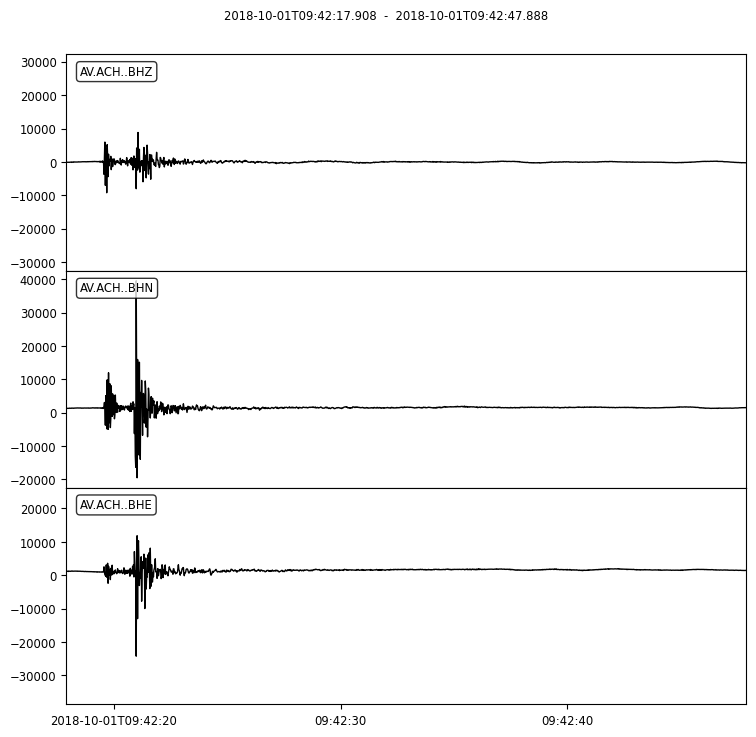

In [167]:
t = mseed[0:3].plot()

#### Convert to numpy arrays

In [168]:
sampling_rate = 100
n_channel = 3
dtype = "float32"
amplitude = True
remove_resp = True

def convert_mseed(mseed, station_locs):
    try:
        mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)
    except:
        logging.error(f"Error: spline detrend failed at file {fname}")
        mseed = mseed.detrend("demean")
    mseed = mseed.merge(fill_value=0)
    starttime = min([st.stats.starttime for st in mseed])
    endtime = max([st.stats.endtime for st in mseed])
    mseed = mseed.trim(starttime, endtime, pad=True, fill_value=0)

    for i in range(len(mseed)):
        if mseed[i].stats.sampling_rate != sampling_rate:
            logging.warning(
                f"Resampling {mseed[i].id} from {mseed[i].stats.sampling_rate} to {sampling_rate} Hz"
            )
            mseed[i] = mseed[i].interpolate(sampling_rate, method="linear")

    order = ['3', '2', '1', 'E', 'N', 'Z']
    order = {key: i for i, key in enumerate(order)}
    comp2idx = {"3": 0, "2": 1, "1": 2, "E": 0, "N": 1, "Z": 2}

    nsta = len(station_locs)
    nt = max(len(mseed[i].data) for i in range(len(mseed)))
    data = []
    station_id = []
    t0 = []
    for i in range(nsta):
        trace_data = np.zeros([nt, n_channel], dtype=dtype)
        empty_station = True
        # sta = station_locs.iloc[i]["station"]
        sta = station_locs.index[i]
        comp = station_locs.iloc[i]["component"].split(",")
        if remove_resp:
            resp = station_locs.iloc[i]["response"].split(",")
            # resp = station_locs.iloc[i]["response"]

        for j, c in enumerate(sorted(comp, key=lambda x: order[x[-1]])):

            resp_j = float(resp[j])
            
            
            if len(comp) != 3:  ## less than 3 component
                j = comp2idx[c]

            if len(mseed.select(id=sta + c)) == 0:
                print(f"Empty trace: {sta+c} {starttime}")
                continue
            else:
                empty_station = False

            tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
            trace_data[: len(tmp), j] = tmp[:nt]

            if station_locs.iloc[i]["unit"] == "m/s**2":
                tmp = mseed.select(id=sta + c)[0]
                tmp = tmp.integrate()
                tmp = tmp.filter("highpass", freq=1.0)
                tmp = tmp.data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            elif station_locs.iloc[i]["unit"] == "m/s":
                tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            else:
                print(
                    f"Error in {station_locs.iloc[i]['station']}\n{station_locs.iloc[i]['unit']} should be m/s**2 or m/s!"
                )
            
            if remove_resp:
                trace_data[:, j] /= resp_j
                
        if not empty_station:
            data.append(trace_data)
            station_id.append(sta)
            t0.append(starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3])

    data = np.stack(data)

    meta = {"data": data, "t0": t0, "station_id": station_id, "fname": station_id}
    
    
    return meta

In [170]:
meta = convert_mseed(mseed, station_locs)

Empty trace: AV.KAHG..EHZ 2018-10-01T09:42:17.908000Z
Empty trace: AV.KJL..BHE 2018-10-01T09:42:17.908000Z
Empty trace: AV.KJL..BHN 2018-10-01T09:42:17.908000Z


## P/S Picks Phasenet

The code below calls an API, posting a dictionary containing 'id', 'timestamp', 'numpy array' passed as a python list, and returns JSON with model-generated P and S picks (time, probability, type)


In [171]:
%%time

PHASENET_API_URL = "http://phasenet.quakeflow.com"

# req = {"id": meta["station_id"], 
#        "timestamp": meta["t0"],
#        "vec": meta["data"].tolist()}
# resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
# phasenet_picks = resp.json()

batch = 4
phasenet_picks = []
for j in range(0, len(meta["station_id"]), batch):
    req = {"id": meta['station_id'][j:j+batch],
        "timestamp": meta["t0"][j:j+batch],
        "vec": meta["data"][j:j+batch].tolist()}

    resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
    phasenet_picks.extend(resp.json())

print('PhaseNet picks')
df = pd.DataFrame(phasenet_picks)
df.head()

PhaseNet picks
CPU times: user 250 ms, sys: 21.6 ms, total: 272 ms
Wall time: 6.03 s


,id,timestamp,prob,amp,type
0,AV.ACH..BH,2018-10-01T09:42:19.528,0.976541,0.000076,p
1,AV.ACH..BH,2018-10-01T09:42:20.918,0.930866,0.000076,s
2,AV.ANCK..BH,2018-10-01T09:42:21.368,0.914994,0.000003,p
3,AV.ANCK..BH,2018-10-01T09:42:23.798,0.851268,0.000003,s
4,AV.KABU..BH,2018-10-01T09:42:19.308,0.981695,0.000031,p


## GaMMA

Takes a set of P- and S-wave arrival picks from a network of stations and associates them into individual earthquake events


NOTE: x,y,z domain bounds are set as parameters. Again, data is passed in JSON format as lists of phasenet_picks and station locations

In [239]:
config = {}
config["xlim_degree"] = [-170,-140]
config["ylim_degree"] = [50,65]

GAMMA_API_URL = "http://gamma.quakeflow.com"

# stations_json = json.loads(station_locs.to_json(orient="records"))
stations_json = station_locs.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0, 41]}

result = requests.post(f'{GAMMA_API_URL}/predict', json= {"picks": phasenet_picks, 
                                                          "stations": stations_json,
                                                           "config": config_gamma})

result = result.json()
catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
print("GaMMA catalog:")
dfC = pd.DataFrame(catalog_gamma)[["time", "latitude", "longitude", "depth(m)", "magnitude", "covariance"]]
display(dfC)
print("GaMMA association:")
dfA = pd.DataFrame(picks_gamma)
# display(dfA)

GaMMA catalog:


,time,latitude,longitude,depth(m),magnitude,covariance
0,2018-10-01T09:42:15.237,58.17243,-155.232183,13715.249876,1.941594,"2.224,0.391,0.278"


GaMMA association:


## OR, you can do both at the same time:

In [245]:
# NOTE: optional you can run both phasenet and gamma with a single API call

PHASENET_API_URL = "http://phasenet.quakeflow.com"

config = {}
config["xlim_degree"] = [-170,-140]
config["ylim_degree"] = [50,65]
stations_json = station_locs.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0, 41]}

req = {"id": meta["station_id"], 
       "timestamp": meta["t0"],
       "vec": meta["data"].squeeze().tolist(),
       "stations": stations_json,
       "config": config_gamma}

resp = requests.post(f'{PHASENET_API_URL}/predict_phasenet2gamma2ui', json=req)
result = resp.json()

Catalog:


,time,latitude,longitude,depth(m),magnitude,covariance
0,2018-10-01T09:42:15.237,58.17243,-155.232183,13715.249876,1.941594,"2.224,0.391,0.278"


Association:


,id,timestamp,prob,amp,type,event_idx,prob_gmma
0,AV.ACH..BH,2018-10-01T09:42:19.528,0.976541,0.000076,p,0,0.081009
1,AV.ACH..BH,2018-10-01T09:42:20.918,0.930866,0.000076,s,0,0.100742
2,AV.ANCK..BH,2018-10-01T09:42:21.368,0.914994,0.000003,p,0,0.059387
3,AV.ANCK..BH,2018-10-01T09:42:23.798,0.851268,0.000003,s,0,0.069766
4,AV.KABU..BH,2018-10-01T09:42:19.308,0.981695,0.000031,p,0,0.101909


### Now we save the QuakeFlow results to a json file:

In [248]:
save_file = 'result_example'

with open(save_file+'.json', 'w') as f:
    json.dump(result, f)

In [28]:
sta_list

['AV.KCE..EH',
 'XO.ET20..HH',
 'AV.KCG..EH',
 'AV.KVT..EH',
 'AV.ANCK..BH',
 'XO.ET19..HH',
 'AV.ANCK..BH',
 'AV.KJL..BH',
 'XO.ET19..HH',
 'AV.KEL..EH',
 'AV.KAHG..BH',
 'AV.Q18K..BH',
 'XO.ET17..HH',
 'XO.EP15..HH',
 'AV.Q18K..BH',
 'AK.R18K..BH',
 'XO.KT06..HH',
 'TA.Q16K..BH',
 'AK.P17K..BH',
 'XO.ET17..HH',
 'XO.EP15..HH',
 'AV.KABU..BH',
 'AV.ACH..BH',
 'AV.KCG..EH',
 'AV.KABU..BH',
 'AV.ACH..BH']